# European Option Pricing with big samples

## GBM

In [1]:
from src.data.make_dataset import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import gmean

In [2]:
# Specify the data loader parameters
n = 1000000
n_steps = 252
n_periods = n_steps/252
gbm_params = {
    "S0": 1., 
    "mu": 0.05,
    "sigma": 0.2, 
    "T": n_periods, 
    "n_points": n_steps+1, 
    "n": n
}

gbm_loader = DataLoader(method="GBM", params=gbm_params, seed=42)
paths_df = gbm_loader.create_dataset(output_type="DataFrame")

In [3]:
annualization_factor = (paths_df.shape[1]-1)/n_periods
log_returns_df = np.log(paths_df).diff(axis=1).iloc[:, 1:]
print("Input mean:\t", np.mean(paths_df.iloc[:, -1]))
print("Expected mean:\t", np.exp(0.05*n_periods))
print("-------------------------------------")
print("Ann. pat stdev:\t", log_returns_df.std(axis=1).mean()*np.sqrt(annualization_factor))
print("Exp. stdev:\t", 0.2)

Input mean:	 1.0509523760890898
Expected mean:	 1.0512710963760241
-------------------------------------
Ann. pat stdev:	 0.19981635929804403
Exp. stdev:	 0.2


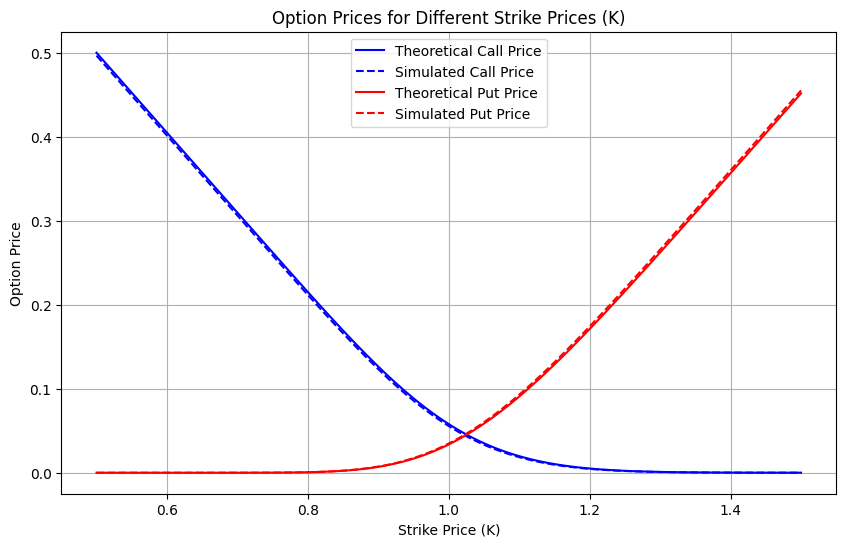

In [4]:
# Parameters
S0 = 1
r = 0.05
T = n_periods
sigma = 0.2

# Define the functions for Asian call and put
asian_call = lambda x: np.maximum(x.apply(gmean, axis=1) - K, 0)
asian_put = lambda x: np.maximum(K - x.apply(gmean, axis=1), 0)

# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.5, 1.5, 100)

# Store results
exact_call_prices = []
exact_put_prices = []
mc_call_ul_prices = []
mc_put_ul_prices = []

for K in K_values:
    M1 = (np.exp(r*T)-1)/(r*T)*S0
    M2 = (
        2*np.exp((2*r+sigma**2)*T)*S0**2 / ((r+sigma**2)*(2*r+sigma**2)*T**2) + 
        2*S0**2 / (r*T**2) * (1/(2*r+sigma**2) - np.exp(r*T)/(r+sigma**2))
    )
    sigma_tilde = np.sqrt(np.log(M2/M1**2)/T)

    d1 = (np.log(M1/K) + sigma_tilde**2*T/2) / (sigma_tilde*np.sqrt(T))
    d2 = d1 - sigma_tilde*np.sqrt(T)

    exact_call_price = np.exp(-r*T)*(M1*norm.cdf(d1) - K*norm.cdf(d2))
    exact_put_price = np.exp(-r*T)*(K*norm.cdf(-d2) - M1*norm.cdf(-d1))

    mc_call_ul_price = np.mean(np.exp(-r*T)*asian_call(paths_df.iloc[:, 1:]))
    mc_put_ul_price = np.mean(np.exp(-r*T)*asian_put(paths_df.iloc[:, 1:]))

    exact_call_prices.append(exact_call_price)
    exact_put_prices.append(exact_put_price)
    mc_call_ul_prices.append(mc_call_ul_price)
    mc_put_ul_prices.append(mc_put_ul_price)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, exact_call_prices, 'b', label='Theoretical Call Price')
plt.plot(K_values, mc_call_ul_prices, 'b--', label='Simulated Call Price')
plt.plot(K_values, exact_put_prices, 'r', label='Theoretical Put Price')
plt.plot(K_values, mc_put_ul_prices, 'r--', label='Simulated Put Price')

plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Option Prices for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()

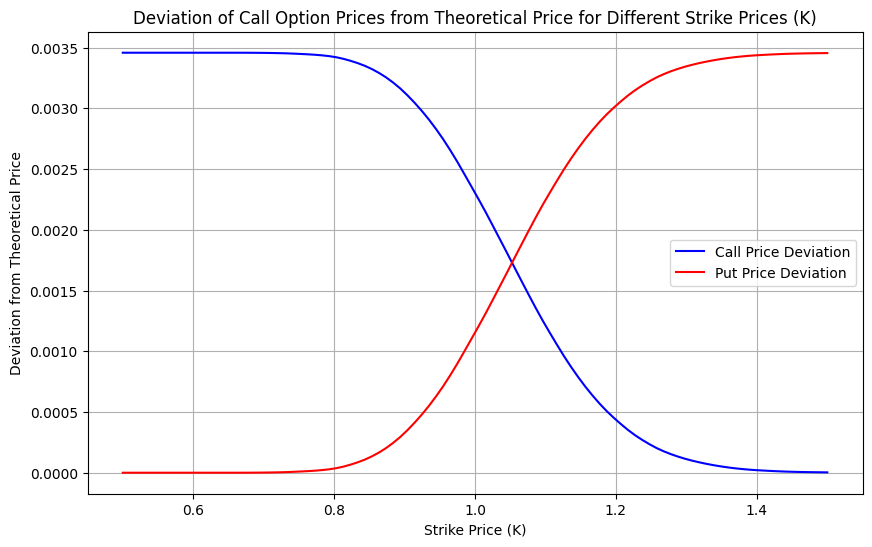

In [5]:
# Store results
ul_call_deviations = abs(np.array(mc_call_ul_prices) - np.array(exact_call_prices))
ul_put_deviations = abs(np.array(mc_put_ul_prices) - np.array(exact_put_prices))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, ul_call_deviations, 'b' ,label='Call Price Deviation')
plt.plot(K_values, ul_put_deviations, 'r',label='Put Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Deviation from Theoretical Price')
plt.title('Deviation of Call Option Prices from Theoretical Price for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()


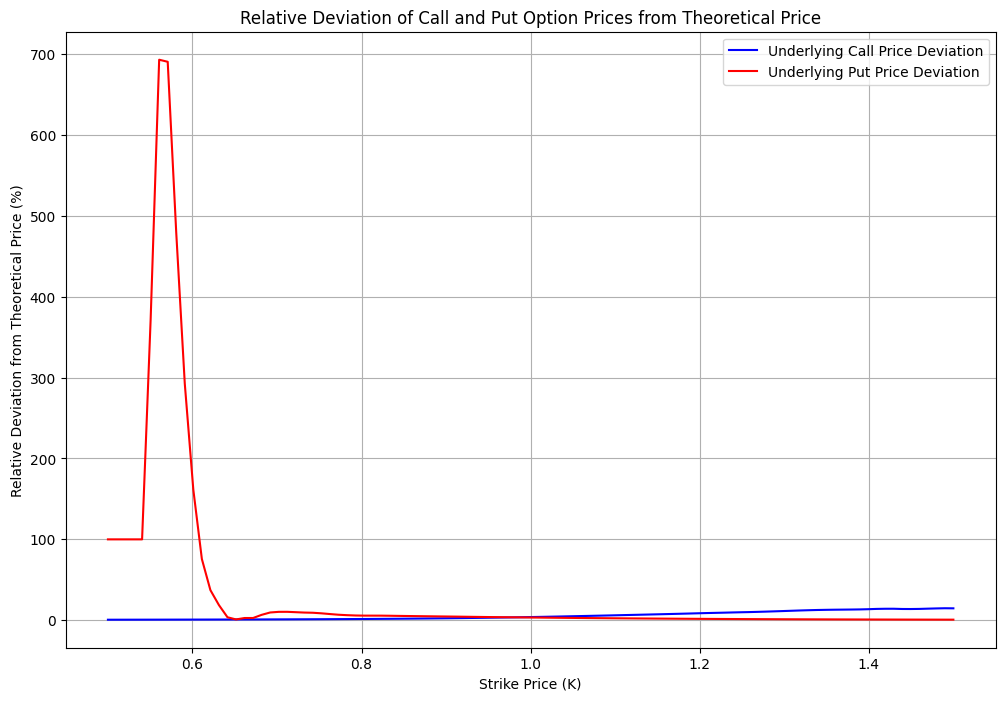

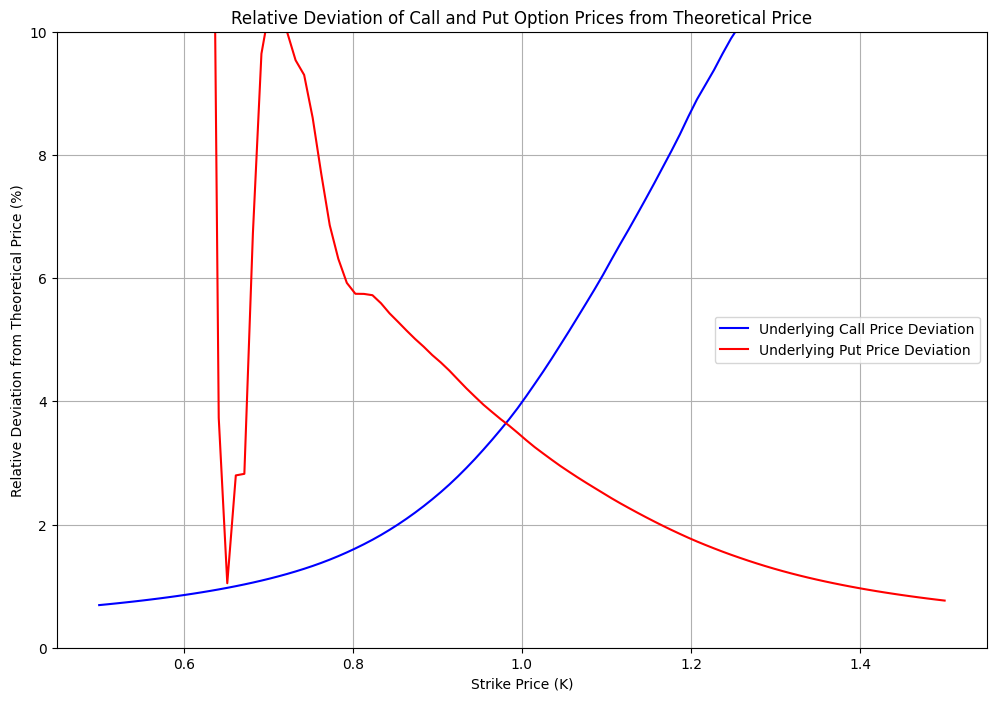

In [12]:
ul_call_deviations_rel = ul_call_deviations / np.array(exact_call_prices) * 100
ul_put_deviations_rel = ul_put_deviations / np.array(exact_put_prices) * 100

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(K_values, ul_call_deviations_rel, 'b', label='Underlying Call Price Deviation')
plt.plot(K_values, ul_put_deviations_rel, 'r', label='Underlying Put Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Relative Deviation from Theoretical Price (%)')
plt.title('Relative Deviation of Call and Put Option Prices from Theoretical Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

plt.plot(K_values, ul_call_deviations_rel, 'b', label='Underlying Call Price Deviation')
plt.plot(K_values, ul_put_deviations_rel, 'r', label='Underlying Put Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Relative Deviation from Theoretical Price (%)')
plt.title('Relative Deviation of Call and Put Option Prices from Theoretical Price')
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.show()